# WATERSTEM - IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

Hello, and welcome back.


The DEF code is a final, cleaned and commented version.
This version implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

# ToDo

- [ ] retrieve unique s0 over the fields (multiple data are duplicated): based on experience, this may be due on errors in the merging of dataframes while using 'nearest' merging methods; UPDATE: same day, different hour -> options: average data / select ascending/descending orbits [choice: average data]; UPDATE: also some same day, same hour
- [ ] retrieve and flag in metadata the true angle of normalization of s0 data [right now fix @ 41°]
- [x] get bounds of soil franco-argilloso from FAO56

In [122]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_io import *
from modules.funcs_pso import *
from modules.funcs_plot import *
from modules.funcs_analysis import *
from modules.IRRI_WCM_model import *
from modules.EPOT_Hargreaves_pyeto import *

In [123]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
     )
verbose = True # if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

# print('\n#-------------WCM model parameters-------------')
units = 'lin' # input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

# print('\n#------------Optimization parameters-----------')
opt_calib = '1' # input('Cost function (KGE) on sigma0 (1) or sigma0 and soil moisture (2)? [1/2]')
opt_cost = 'KGE'

print('\n#------------Field parameters-----------')
opt_field = input('San Lorenzo 1 or 2? [1/2]')
opt_year = input('Choose a year for calibration (1/1 to 31/12) or "whole" period')
if not opt_year=='whole': opt_year=int(opt_year)
opt_static =  input('Do you want to fix static parameters A,B,D? [y/n]')
if opt_static=='y':
    opt_root =    input('Provide root folder for static parameters log.')
    opt_pattern = input('Provide pattern to match for parameters log (can use wildcards).')
    PAR_dict_static = read_json(search_fname(opt_root, opt_pattern))

print('\n#------------Calibration parameters-----------')
PAR_str_add = '_' + input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

# check if params are already present
# opt_params = input('Params already present: overwrite [y] or append [n]? [y/n]') if len(params) else ''
# if opt_params=='y': params = []

Starting...
#-------------------------------------------------------------


#------------Field parameters-----------

#------------Calibration parameters-----------


In [124]:
# Plotter for all columns of data

def plot_columns(df):
    fig, ax = plt.subplots(figsize=(14,6))
    
    for column in df.columns:
        if df[column].dtype == 'object':
            continue  # Skip non-numeric columns
        
        ax.plot(df.index, df[column], label=column)
    
    ax.legend()
    plt.show()

In [125]:
#############################################################################
# METACODING
#############################################################################

def check_non_unique_index(df):
    non_unique_index = df.index.duplicated(keep=False)
    if non_unique_index.any():
        non_unique_labels = df.index[non_unique_index]
        print("Non-unique index labels:")
        print(non_unique_labels)

In [126]:
# File paths
# ----------
# Meteo data
file_meteo             = './Pascoli_UNIFI_dati_meteo/Daily_precipitation_SanLorenzo.csv'
file_temp              = './Pascoli_UNIFI_dati_meteo/Daily_temperatures_SanLorenzo.csv'
file_pet_sanlorenzo1   = './Pascoli_UNIFI_PET/PET_SanLorenzo1.csv'
file_pet_sanlorenzo2   = './Pascoli_UNIFI_PET/PET_SanLorenzo2.csv'
file_ndvi_sanlorenzo1  = './Pascoli_UNIFI_NDVI/NDVI_SanLorenzo1.csv'
file_ndvi_sanlorenzo2  = './Pascoli_UNIFI_NDVI/NDVI_SanLorenzo2.csv'


# s0 data
file_s0_sanlorenzo1 = './Pascoli_UNIFI_mean-sigma0/sanlorenzo1.csv'
file_s0_sanlorenzo2 = './Pascoli_UNIFI_mean-sigma0/sanlorenzo2.csv'



# Dataframes
# ----------
# Meteo data
df_meteo            = pd.read_csv(file_meteo);
df_temp             = pd.read_csv(file_temp);
df_pet_sanlorenzo1  = pd.read_csv(file_pet_sanlorenzo1)
df_pet_sanlorenzo2  = pd.read_csv(file_pet_sanlorenzo2)
df_ndvi_sanlorenzo1 = pd.read_csv(file_ndvi_sanlorenzo1, delimiter=';');
df_ndvi_sanlorenzo2 = pd.read_csv(file_ndvi_sanlorenzo2, delimiter=';');

# s0 data
df_s0_sanlorenzo1   = pd.read_csv(file_s0_sanlorenzo1, delimiter='\t');
df_s0_sanlorenzo2   = pd.read_csv(file_s0_sanlorenzo2, delimiter='\t');

In [127]:
len(pd.read_csv(file_ndvi_sanlorenzo2, delimiter=';'))

142

In [128]:
# Set daily, DateTimeIndex for all dataframes
df_meteo['Date'] = [pd.to_datetime(x.date()) for x in pd.to_datetime(df_meteo['Date'], format='%d/%m/%Y')];
df_meteo.set_index('Date', inplace=True);

# meteo dataframe - cleaning
for df in [
    df_temp,
    df_pet_sanlorenzo1,
    df_pet_sanlorenzo2,
    df_ndvi_sanlorenzo1,
    df_ndvi_sanlorenzo2,
    df_s0_sanlorenzo1,
    df_s0_sanlorenzo2,
]:
    # df['Date'] = [pd.to_datetime(x.date()) for x in pd.to_datetime(df['Date'],  format='mixed')]
    df['Date'] = [pd.to_datetime(x.date()) for x in pd.to_datetime(df['Date'],  infer_datetime_format=True)]
    df.set_index('Date', inplace=True);

In [129]:
check_non_unique_index(df_s0_sanlorenzo1)

Non-unique index labels:
DatetimeIndex(['2016-01-28', '2016-01-28', '2016-01-29', '2016-01-29',
               '2016-02-04', '2016-02-04', '2016-10-07', '2016-10-07',
               '2016-10-13', '2016-10-13',
               ...
               '2021-11-28', '2021-11-28', '2021-12-04', '2021-12-04',
               '2021-12-10', '2021-12-10', '2021-12-16', '2021-12-16',
               '2021-12-22', '2021-12-22'],
              dtype='datetime64[ns]', name='Date', length=602, freq=None)


In [130]:
# s0 dataframe - cleaning
df_s0_sanlorenzo1['data'] = df_s0_sanlorenzo1.index
df_s0_sanlorenzo2['data'] = df_s0_sanlorenzo2.index
df_s0_sanlorenzo1 = df_s0_sanlorenzo1.groupby('data').mean(numeric_only=True)
df_s0_sanlorenzo2 = df_s0_sanlorenzo2.groupby('data').mean(numeric_only=True)

In [131]:
check_non_unique_index(df_s0_sanlorenzo1)

In [132]:
# Clean useless columns

# Meteo data
df_meteo.drop(df_meteo.columns.difference(['Prec_mm']), axis=1, inplace=True)
# df_temp.drop()

# PET data (from MODIS16A) are the sum over a 8 days period, so need to be divided by 8
# No conversion factor is needed for units of measurements since kg/m^2/day = mm/day
df_pet_sanlorenzo1['PET_mean[mm/day]'] = df_pet_sanlorenzo1['PET_mean (kg/m2/8day)']/8
df_pet_sanlorenzo2['PET_mean[mm/day]'] = df_pet_sanlorenzo2['PET_mean (kg/m2/8day)']/8
df_pet_sanlorenzo1.drop(df_pet_sanlorenzo1.columns.difference(['PET_mean[mm/day]']), axis=1, inplace=True)
df_pet_sanlorenzo2.drop(df_pet_sanlorenzo2.columns.difference(['PET_mean[mm/day]']), axis=1, inplace=True)
df_pet_sanlorenzo1 = df_pet_sanlorenzo1.resample('D').asfreq().interpolate(method='linear')
df_pet_sanlorenzo2 = df_pet_sanlorenzo2.resample('D').asfreq().interpolate(method='linear')
    
df_ndvi_sanlorenzo1.drop(df_ndvi_sanlorenzo1.columns.difference(['NDVI_mean']), axis=1, inplace=True)
df_ndvi_sanlorenzo2.drop(df_ndvi_sanlorenzo2.columns.difference(['NDVI_mean']), axis=1, inplace=True)
df_ndvi_sanlorenzo1 = df_ndvi_sanlorenzo1.resample('D').asfreq().interpolate(method='linear')
df_ndvi_sanlorenzo2 = df_ndvi_sanlorenzo2.resample('D').asfreq().interpolate(method='linear')

# s0 data
df_s0_sanlorenzo1.drop(df_s0_sanlorenzo1.columns.difference(['VV_norm[dB]']), axis=1, inplace=True)  
df_s0_sanlorenzo2.drop(df_s0_sanlorenzo2.columns.difference(['VV_norm[dB]']), axis=1, inplace=True)

In [133]:
# Merge dataframes for both sanlorenzo1 and sanlorenzo2 (suffixes _1, _2)
# Daily data to use as input in SWB
df0 = pd.merge(df_ndvi_sanlorenzo1, df_ndvi_sanlorenzo2, left_index=True, right_index=True, suffixes=['_1', '_2']);
df1 = pd.merge_asof(df_meteo, df_temp, left_index=True, right_index=True)
df2 = pd.merge(df1, df_pet_sanlorenzo1, left_index=True, right_index=True)
df3 = pd.merge_asof(df2, df_pet_sanlorenzo2, left_index=True, right_index=True, suffixes=['_1', '_2'])
df4 = pd.merge(df3, df0, left_index=True, right_index=True).dropna(); df4

,Prec_mm,T_MAX,T_MIN,PET_mean[mm/day]_1,PET_mean[mm/day]_2,NDVI_mean_1,NDVI_mean_2
Date,,,,,,,
2017-04-25,0.0,19.1,8.9,4.398047,4.301414,0.732104,0.680660
2017-04-26,0.4,18.1,12.7,4.418093,4.326228,0.727535,0.680526
2017-04-27,15.8,19.0,11.2,4.438139,4.351042,0.722965,0.680393
2017-04-28,4.2,15.5,3.8,4.458185,4.375856,0.718396,0.680259
2017-04-29,0.0,17.3,1.7,4.478232,4.400670,0.713826,0.680125
...,...,...,...,...,...,...,...
2022-10-26,0.0,24.6,11.7,2.389706,2.349162,0.550970,0.526336
2022-10-27,0.2,24.8,10.8,2.287794,2.247523,0.555710,0.531955
2022-10-28,0.2,26.4,9.9,2.185882,2.145884,0.560450,0.537574


In [134]:
import json

root_shapefile = '../Inputs/Shapefiles/Pascoli_UNIFI/'
fname_shapefile = 'SanLorenzo'+opt_field+'.json'

with open(root_shapefile+fname_shapefile) as file: shapefile = json.load(file)
coordinates = shapefile['features'][0]['geometry']['coordinates'];
lons = np.array([x[0] for x in coordinates[0]])
lats = np.array([x[1] for x in coordinates[0]])
mean_lats = (lats.min()+lats.max())/2; mean_lats
lat_deg = mean_lats # latitude (deg)

df = df4
temp_tag = ['T_MIN','T_MAX']
temp_min = df[temp_tag[0]].values
temp_max = df[temp_tag[1]].values
temp_mean = (temp_min+temp_max*2)/3
dates = df.index; dates.values
eto = timeseries( dates,
                 [
                     hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates))
                 ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'PET_Hargre[mm/day]'}).set_index('Date')

In [135]:
input_swb = pd.merge(df4, eto_df, left_index=True, right_index=True); input_swb

,Prec_mm,T_MAX,T_MIN,PET_mean[mm/day]_1,PET_mean[mm/day]_2,NDVI_mean_1,NDVI_mean_2,PET_Hargre[mm/day]
Date,,,,,,,,
2017-04-25,0.0,19.1,8.9,4.398047,4.301414,0.732104,0.680660,3.592727
2017-04-26,0.4,18.1,12.7,4.418093,4.326228,0.727535,0.680526,2.676440
2017-04-27,15.8,19.0,11.2,4.438139,4.351042,0.722965,0.680393,3.244555
2017-04-28,4.2,15.5,3.8,4.458185,4.375856,0.718396,0.680259,3.435155
2017-04-29,0.0,17.3,1.7,4.478232,4.400670,0.713826,0.680125,4.056140
...,...,...,...,...,...,...,...,...
2022-10-26,0.0,24.6,11.7,2.389706,2.349162,0.550970,0.526336,2.269600
2022-10-27,0.2,24.8,10.8,2.287794,2.247523,0.555710,0.531955,2.324335
2022-10-28,0.2,26.4,9.9,2.185882,2.145884,0.560450,0.537574,2.541877


In [136]:
# Check consistency of PET data from Hargreaves formula with MODIS derived
Rvalue(input_swb['PET_mean[mm/day]_1'], input_swb['PET_Hargre[mm/day]'])
bias(input_swb['PET_mean[mm/day]_1'], input_swb['PET_Hargre[mm/day]'])
np.mean(input_swb['PET_Hargre[mm/day]'])
np.mean(input_swb['PET_mean[mm/day]_1'])

3.7370603608477118

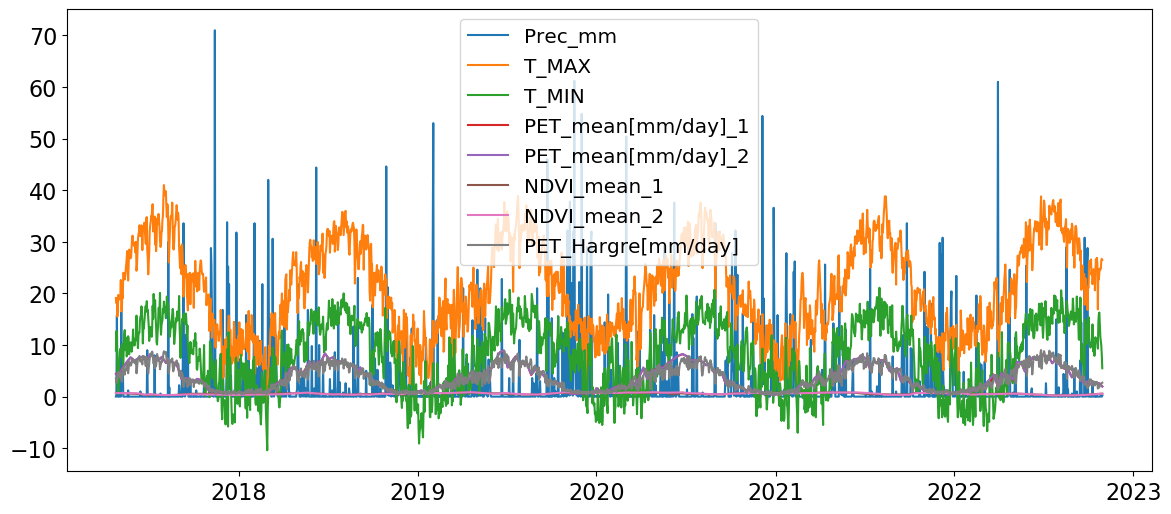

In [137]:
plot_columns(input_swb)

In [138]:
# Merge dataframes for both sanlorenzo1 and sanlorenzo2 (suffixes _1, _2)
# Multi-daily data to use as input in WCM
df1 = pd.merge(df_ndvi_sanlorenzo1, df_ndvi_sanlorenzo2, left_index=True, right_index=True, suffixes=['_1', '_2']);
df2 = pd.merge(df1, df_s0_sanlorenzo1, left_index=True, right_index=True);

input_wcm = pd.merge(df2, df_s0_sanlorenzo2, left_index=True, right_index=True, suffixes=['_1', '_2']); input_wcm

,NDVI_mean_1,NDVI_mean_2,VV_norm[dB]_1,VV_norm[dB]_2
2017-04-24,0.736674,0.680794,-12.560054,-13.277316
2017-04-28,0.718396,0.680259,-11.331814,-12.271658
2017-04-29,0.713826,0.680125,-11.411836,-12.005928
2017-04-30,0.709257,0.679991,-11.443710,-11.998711
2017-05-04,0.690979,0.679456,-10.719611,-11.650502
...,...,...,...,...
2022-10-18,0.509559,0.479345,-11.186603,-12.265392
2022-10-19,0.516046,0.485985,-12.323991,-13.140396
2022-10-23,0.536752,0.509480,-12.506499,-13.229550
2022-10-24,0.541491,0.515099,-11.999343,-12.927173


In [139]:
# List of dates
if opt_year=='whole': t = [x for x in input_swb.index]
else: t = [x for x in input_swb.index if x.year==opt_year]

# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))

if opt_year=='whole': t_sat = [x for x in intersect]
else: t_sat = [x for x in intersect if x.year==opt_year]


P       = input_swb.loc[t]['Prec_mm'].values # [mm]
EPOT    = input_swb.loc[t]['PET_Hargre[mm/day]'].values # [mm/day]
# EPOT    = input_swb.loc[t][f'PET_mean[mm/day]_{opt_field}'].values # [mm/day]
rho_st  = 0.6 # standard depletion fraction [grazing pasture, Table 22]

# Crop coefficient curve is assumed equal to NDVI curve (daily)
# According to FAO56 Kc values for pasture are in [0.3, 0.8]
# which is compatible with the range of NDVI values
# Kc = Kc_curve(year, t)
Kc      = input_swb.loc[t][f'NDVI_mean_{opt_field}'].values # [-]
veg     = input_wcm.loc[t_sat][f'NDVI_mean_{opt_field}'].values # [-]

angle   = np.array([41]*len(t_sat)) # input_wcm.loc[t_sat]['Angle'].values # [°]
s0      = input_wcm.loc[t_sat][f'VV_norm[dB]_{opt_field}'].values # [dB]
freq    = 1.4 # 6, 4, 1.4     # [GHz] frequency for DoI computation

# Soil texture list
# 28,7% sabbia, 36,0% limo, 35,3% argilla
soil = [28.7, 35,3] # [sand, clay]
WW_sat = 0.51
WW_fc = 0.35 # np.mean([0.24, 0.40])
WW_w = 0.12 # np.mean([0.07, 0.24])

# List of inputs for calibrating the model
inputs  = [t, t_sat, P, EPOT, Kc, veg, angle, s0, freq, rho_st, soil, WW_sat, WW_fc, WW_w]

# SWB+WCM model, daily

In [140]:
#############################################################################
# Soil Water Balance + Water Cloud model daily
# No irrigation
#############################################################################

def SWB_WCM_WATERSTEM(PAR, inputs, user_in):
    """Soil Water Balance and Water Cloud Model integration

    The soil water balance model (SWB) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).

    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
    - inputs: input quantities for calibration

    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.

    """

    # User_in options
    # opt_static = user_in # deprecated, here for compatibility

    # Inputs
    A, B, C, D, Kc0 = PAR
    t, t_sat, P, EPOT, Kc, veg, angle, s0, freq, rho_st, soil, WW_sat, WW_fc, WW_w = inputs

    angle_m = np.mean(angle)
    Ks      = 0. # water stress coefficient
    rho     = 0. # depletion fraction
    WW      = np.array([0.2]*len(t), dtype=float) # water content [m3/m3]
    WW[0]   = .2 # initial value of sm [m3/m3]
    depth   = 0. # dynamic depth [mm]

    COST   = .0   # additional cost to KGE
    LAMBDA = 1000 # Lagrange multiplier

    for i in [i+1 for i in range(len(t)-1)]:

        # Compute DoI of W[i-1]
        depth = (doi(freq=freq,
                     sand=soil[0], clay=soil[1],
                     water=WW[i-1],
                     angle=angle_m)\
                    *1000)+50 # *1000 accounts for going from [m] to [mm]

        # Build Ks curve
        # Compute crop coeff and depletion fraction
        rho = rho_st+0.04*(5-Kc[i]*Kc0*EPOT[i]) # [mm/day]
        if   rho<0.1: COST += (rho-0.1)**2      # regularization
        elif rho>0.8: COST += (rho-0.8)**2      # regularization

        if WW[i-1]>=((1-rho)*WW_fc+rho*WW_w):
            Ks=1.
        elif (WW[i-1]<((1-rho)*WW_fc+rho*WW_w))and(WW[i-1]>WW_w):
            Ks=((WW[i-1]-WW_w)/((1-rho)*(WW_fc-WW_w)))
        else: Ks=0.

        # Water balance [mm]
        WW[i]=WW[i-1]+(P[i]-EPOT[i]*Kc[i]*Kc0*Ks)/depth

        # Computation of deep percolation (water above field capacity)
        if WW[i]>WW_fc: WW[i]=WW_fc

        # Regularization for non-physical data below wilting point
        # if WW[i]<WW_w: COST += (WW[i]-WW_w)**2

    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])

    # Water Cloud Model
    s0_sim,KGE = WCM([A,B,C,D], [WWsat,veg,angle,s0])

    KGE += -LAMBDA*COST

    return [WW,s0_sim,KGE]


In [141]:
def calc_depth(freq:float, soil:list, water:list, angle:float)->list:
    depth = [doi(freq=freq, sand=soil[0], clay=soil[1], water=w, angle=angle)*1000 for w in water]
    return depth


def calc_rho(rho_st:float, Kc:list, Kc0:float, EPOT:list)->list:
    rho = [rho_st+0.04*(5-Kc[i]*Kc0*EPOT[i]) for i in range(len(Kc))]
    return rho


def calc_Ks(WW:list, rho:list, WW_fc, WW_w)->list:
    t = len(WW)
    Ks = []
    for i in range(t):
        if WW[i-1]>=((1-rho)*WW_fc+rho*WW_w):
            Ks.append(1)
        elif (WW[i-1]<((1-rho)*WW_fc+rho*WW_w))and(WW[i-1]>WW_w):
            Ks.append((WW[i-1]-WW_w)/((1-rho)*(WW_fc-WW_w)))
        else: Ks.append(0)
    return Ks

In [142]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,s0_sim,KGE = SWB_WCM_WATERSTEM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

# Calibration SWB+WCM

In [143]:
# Calibration SWB+WCM
# ----------------------------------------------------------------------------

# Guess parameters for WCM
A      = 0.3; B      = 1.5; C      = -15; D      = 30   # guess values for WCM parameters
Kc0    = 1    # [-] scaling factor for crop specific coefficient

# PAR default
PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']
PAR_str_stat = [r'$A$', r'$B$', r'$D$'] # static parameters, don't change in time, site-dependent

# PAR to calibrate
# A, B, C, D, d_0, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, Kc0]
PARn_str= [r'$A$', r'$B$', r'$C$', r'$D$', r'$K_{c0}$']

bounds = (
    np.array([0, 0, -30,  10, 0], dtype=float), # low
    np.array([5, 3,  -5, 100, 2], dtype=float), # up
    )

In [144]:
# PAR static
user_in = opt_static

if opt_static=='y':

    PS = [] # PAR_static
    E = [] # devs of PAR static
    # Static parameters are appended to inputs
    for key in PAR_dict_static.keys():
        d = PAR_dict_static[key]
        if d[1]=='cal':
            PS.append(d[3])
            E.append(d[4])

    A, B, C, D, Kc0 = PS
    PAR     = PS
    bounds = (
        np.array([PS[0]-E[0], PS[1]-E[1], -30, PS[3]-E[3], 0], dtype=float), # low
        np.array([PS[0]+E[0], PS[1]+E[1],  -5, PS[3]+E[3], 2], dtype=float), # up
        )

In [145]:
print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')

from pyswarms.backend.handlers import OptionsHandler

# if opt_params=='y':
params = []
start = time.time()
for i in range(int(nrun)):
    print('Run number ', i+1)

    optim='global'
    options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
    oh_strategy = {"w":'lin_variation', 'c1':'lin_variation', 'c2':'lin_variation'}
    bh_strategy = 'shrink'
    vh_strategy = 'invert'
    init_pos = np.array([PAR]*int(n_particles))
    optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                        dimensions=len(PAR),
                                        options=options,
                                        bounds=bounds,
                                        oh_strategy=oh_strategy,
                                        bh_strategy=bh_strategy,
                                        vh_strategy=vh_strategy,
                                        init_pos=init_pos,
                                       )
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)
    params.append(PARn)
    end = time.time()

    if i==0:
        time_sec = round(end-start, 2)
        time_min =  round((end-start)/60, 2)
        print(time_min, ' min for last run,', time_min*nrun , ' min estimated')
    print('Time left: ', round((start+time_sec*nrun-end)/60,2), 'min')

timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)

2024-01-16 16:23:50,911 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Starting calibration...
#-------------------------------------------------------------

Run number  1


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.616
2024-01-16 16:24:11,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6163058695607162, best pos: [ 2.98547461e+00  3.87484753e-03 -1.52792804e+01  1.15958660e+01
  2.00000000e+00]


0.34  min for last run, 0.34  min estimated
Time left:  -0.0 min
Timestring:  240116-162411


In [146]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

Timing:  0.34  min for 1 run, 0.34 min total


In [147]:
print('\n#--------------------------------------------------\n',f'Filename=sanlorenzo{opt_field}_{opt_year}_{timestr}_*')
timestr=f'sanlorenzo{opt_field}_{opt_year}_{timestr}'


#--------------------------------------------------
 Filename=sanlorenzo1_2022_240116-162411_*


In [148]:
root = 'Plot/'

# Parameters' study

In [149]:
#############################################################################
# Analysis on parameters out of multiple runs
#############################################################################

def parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10, opt_fit=True):
    
    matrix = np.array(
        [
            np.array(
                [ params[i][j] for i in range(len(params)) ])
            for j in range(len(PAR))
        ]
    )
    
    PAR_dict = {
        r'$A$':         [r'$[-]$',          round(A, 2) ],
        r'$B$':         [r'$[-]$',          round(B, 2) ],
        r'$C$':         [r'$[dB]$',         round(C, 2) ],
        r'$D$':         [r'$[dB m^3/m^3]$', round(D, 2) ],
        # r'$\delta_0$':  [r'$[mm]$',         round(d_0, 2) ],
        r'$W_{fc}$':    [r'$[m^3/m^3]$',    round(WW_fc, 2) ],
        r'$W_w$':       [r'$[m^3/m^3]$',    round(WW_w, 2) ],
        r'$\rho_{st}$': [r'$[mm/h]$',       round(rho_st, 2) ],
        r'$K_{c0}$' :   [r'$[-]$',          round(Kc0, 2)],
    }

    PARn = []
    PARn_dev = []
    rowLabels = []
    
    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False

    opt_show = True
    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            data = matrix[i]
            
            if len(data)==1:
                PARn=[x[0] for x in matrix]
                PARn_dev=[0 for x in matrix]
            else:
                hist_kwargs={'alpha':.5, }
                fitline_kwargs={'linestyle':'-',}
                counts, bins, pads, popt, pcov, q1, q2, q3, mode = hist_gauss_fit(
                    data, nbins=nbins, hist_kwargs=hist_kwargs,
                    fitline_kwargs=fitline_kwargs,
                    title=f'{label} {PAR_dict[label][0]}', density=True,
                    opt_save=opt_save, dir_name=root,
                    opt_name=f'{timestr}_hist_{i}',
                    opt_fit=opt_fit,
                    func=gauss, fit_method='dogbox')
                mean=np.mean(data); rang=np.ptp(data)
                plt.xlim(mean-rang, mean+rang);
                
                PARn.append(q2)
                PARn_dev.append((q3-q1)/2)
                plt.show()

            if opt_show: plt.show()
            else: plt.close()

            PAR_dict[label].pop(1)
            PAR_dict[label].append('cal');
            PAR_dict[label].append([int(round(bounds[0][i],2)), int(round(bounds[1][i],2))]);
            PAR_dict[label].append(round(PARn[i], 3));
            PAR_dict[label].append(round(PARn_dev[i], 3));
            PAR_dict[label].append(list(matrix[i]));
            
            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Median' in rowLabels: rowLabels.append('Median')
            if not 'Err' in rowLabels: rowLabels.append('Err')
            
        else:
            PAR_dict[label].append('fix')
            PAR_dict[label].append(['/', '/'])
            PAR_dict[label].append(PAR_dict[label][1])
            PAR_dict[label].append('/')
            PAR_dict[label].pop(1)
    
    print(PAR_dict, '\n', rowLabels)
    return PAR_dict, rowLabels

In [150]:
PAR_dict, rowLabels = parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10, opt_fit=False,)

{'$A$': ['$[-]$', 'cal', [0, 5], 2.985, 0, [2.985474613438501]], '$B$': ['$[-]$', 'cal', [0, 3], 0.004, 0, [0.0038748475262369445]], '$C$': ['$[dB]$', 'cal', [-30, -5], -15.279, 0, [-15.279280374395455]], '$D$': ['$[dB m^3/m^3]$', 'cal', [10, 100], 11.596, 0, [11.59586595821821]], '$W_{fc}$': ['$[m^3/m^3]$', 'fix', ['/', '/'], 0.35, '/'], '$W_w$': ['$[m^3/m^3]$', 'fix', ['/', '/'], 0.12, '/'], '$\\rho_{st}$': ['$[mm/h]$', 'fix', ['/', '/'], 0.6, '/'], '$K_{c0}$': ['$[-]$', 'cal', [0, 2], 2.0, 0, [2.0]]} 
 ['Cal/fix', 'Bounds', 'Median', 'Err']


In [151]:
import json

if automate: opt_save=True
else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False

if opt_save:
    fname_params = '_params.json'
    path_params = root+timestr+fname_params
    with open(path_params, 'w') as file: json.dump(PAR_dict, file)
    file.close()

# Model output - plots sim VS obs for SM, sigma0

In [152]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.10, 0.3, 0.5]
        print(PAR_tot)
        WW,sigma0,KGE = SWB_WCM_WATERSTEM(PAR_tot, inputs, user_in)
    else: WW,sigma0,KGE = SWB_WCM_WATERSTEM(PARn, inputs, user_in) # components = (Ks, rho, depth)

else:
    PARn = [PAR_dict[label][3] for label in PAR_dict if label in PARn_str]
    WW,sigma0,KGE = SWB_WCM_WATERSTEM(PARn, inputs, user_in)

In [153]:
PARn

[2.985, 0.004, -15.279, 11.596, 2.0]

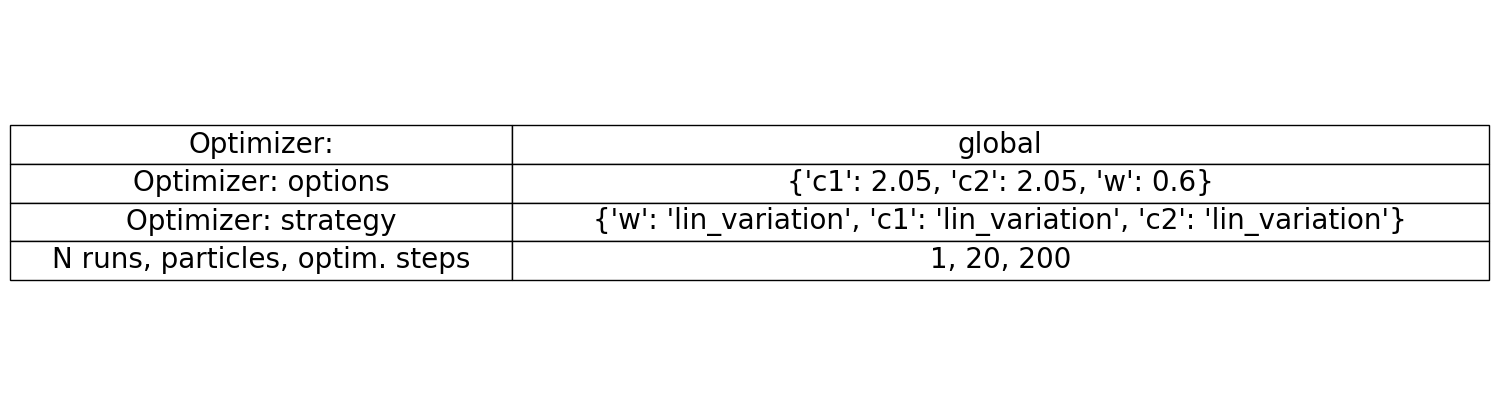

In [154]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(len(params))+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(root+timestr+'_table_mach.svg', dpi=100)
plt.show()

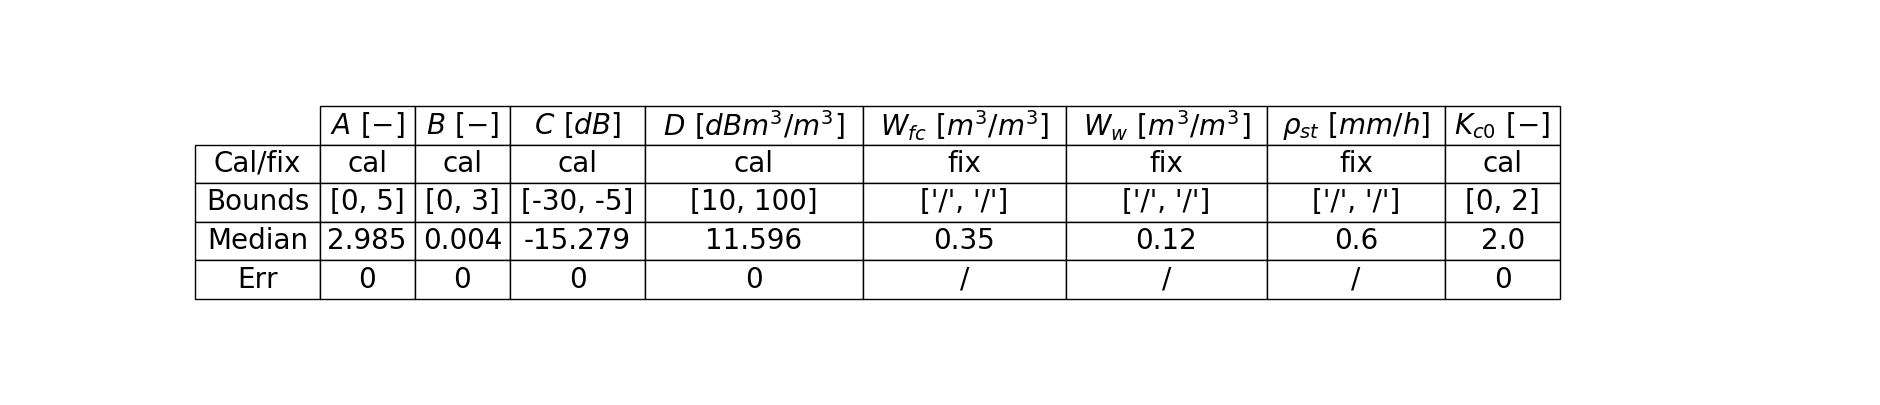

In [155]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

single_label = [label for label in PAR_dict][0]
cellText = [
    [
        significant_figures_str(PAR_dict[label][4],PAR_dict[label][i])[1] if (PAR_dict[label][3]=='cal') and (type(PAR_dict[label][i])==float)
        else PAR_dict[label][i]
        for label in PAR_dict
    ] 
    for i in range(1,1+len(rowLabels))]

colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
# rowLabels = [ 'Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                 cellLoc='center', loc='center',
                 colLabels=colLabels,
                 rowLabels=rowLabels,
                 )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(root+timestr+'_table.svg')
plt.show()

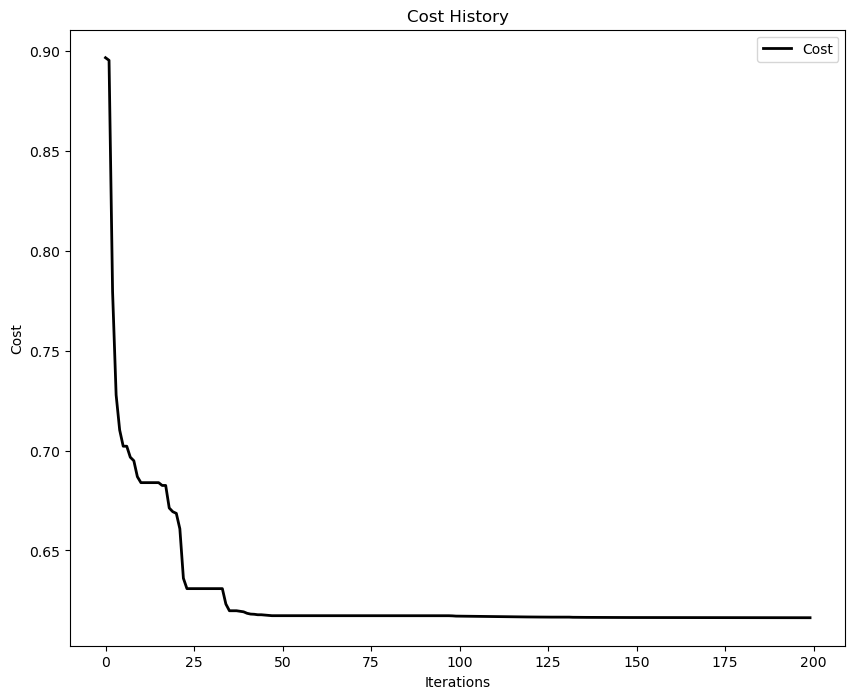

In [156]:
from pyswarms.utils.plotters import plot_cost_history

# Obtain cost history from optimizer instance
cost_history = optimizer.cost_history

# Plot!
plot_cost_history(cost_history)
plt.show()

## Plotters

In [157]:
#############################################################################
# Plotting options (rcParams)
#############################################################################

rc_dict = {
    'axes.titlesize' : 16,
    'axes.labelsize' : 16,
    # lines.linewidth : 3,
    # lines.markersize : 10,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'legend.fontsize' : 'x-large',
}
    
#############################################################################
# Triple plot
#############################################################################

# mplt.rc_context(rc_dict)
def plot_triple(fig, ax, times1:list, data1:list, data1_label:str, 
                input1:list, input1_label:str,
                times2:list, data2:list, data2_label:str,
                input2:list, input2_label:str,
                times3:list, data3:list, data3_label:list,
                user_input:list,
               ):
    """3 subplots with 2 sim VS obs timeseries and eventual inputs
    
    Inputs
    ------
    - data1: list(obs, sim)
    - data1_label: label of the quantity
    - input1: list()
    - data2: list(obs, sim)
    - data2_label: label of the quantity
    - input2: list()
    - ...
    
    Note: figure, saving options to be defined outside
    """
    
    mplt.rcParams.update(rc_dict)
    
    #----------------------------------------------------------------------
    # Plot 1 sim vs obs timeseries
    
    obs = data1[0]; obs_label=data1_label+'_obs'
    sim = data1[1]; sim_label=data1_label+'_sim'
    labely = data1_label
    times = [x.to_pydatetime() for x in times1]
    marker='o'; linestyle='-'
    units=r' $[dB]$'
    
    # RMSE, R, bias, KGE calculation
    RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
    R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
    BIAS=bias(sim,obs); print('bias =', BIAS)
    KGE=he.evaluator(he.kge, sim, obs)[0,:][0]; print('KGE=', KGE)
    
    title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={BIAS:.2f}, KGE={KGE:.2f}'
    
    # ax[0].set_xlim(xmin=times[0], xmax=times[-1])
    ax[0].plot(times, sim, c='tab:red', label=sim_label,
               linestyle=linestyle, lw=1, marker=marker, ms=1)#alpha=.4, zorder=-1)
    ax[0].plot(times, obs, c='tab:blue', label=obs_label,
               linestyle=linestyle, lw=1, marker=marker, ms=1,
               alpha=.4, zorder=-1)
    ax[0].legend(loc='upper left')
    ax[0].set_title(title)
    ax[0].set_ylabel(labely+units, size='xx-large')
    
    units = r' $[-]$'
    ax0 = ax[0].twinx()
    ax0.plot(times, input1, label=input1_label, color='tab:green', lw=1)
    ax0.legend(loc='upper right')
    ax0.set_ylabel(input1_label+units, size='xx-large')
    
    
    #-----------------------------------------------------------------------
    # Plot 2 sim vs obs timeseries
    
    sim = data2[0]; sim_label=data2_label+'_sim'
    labely = data2_label
    times = [x.to_pydatetime() for x in times2]
    units = r' $[m^3/m^3]$'
    
    title=f'{sim_label}'
    
    ax[1].set_xlim(xmin=times[0], xmax=times[-1])
    ax[1].plot(times, sim, c='tab:red', label=sim_label)
    ax[1].legend(loc='upper left')
    ax[1].set_title(title)
    ax[1].set_ylabel(data2_label+units, size='xx-large')
    
    #-----------------------------------------------------------------------
    # Plot of inputs P, EPOT
    
    label1, label2 = data3_label
    times = [x.to_pydatetime() for x in times3]
    units = r' $[mm]$'
    
    ax[2].bar(times, data3[0], color='tab:gray', label=label1, )
    ax[2].legend(loc='upper left')
    ax[2].set_ylabel(label1+', '+label2+units, size='xx-large')
    
    ax2 = ax[2].twinx()
    ax2.plot(times, data3[1], label=label2, color='tab:green')
    ax2.legend(loc='upper right')
    ax2.set_ylabel(label2+r' $[mm/day]$', size='xx-large')
    
    
    #-----------------------------------------------------------------------
    
    ax[0].set_ylim(-18, -7)
    ax0.set_ylim(0, 1)
    ax[1].set_ylim(0, .6)
    ax[2].set_ylim(0, 100)
    ax2.set_ylim(0, 10)    
        
        
#############################################################################
# Scatter plot
#############################################################################

def plot_sim_vs_obs(sim:list, obs:list, quantity:str, um:str):
    
    import matplotlib.gridspec as gridspec
    
    def linear(x,a,b):
        return a+b*x
    
    title = f'{quantity} obs VS simul - ' # y VS x
    xlabel = f'{quantity}_sim {um}'
    ylabel = f'{quantity}_obs {um}'
    
    data = pd.DataFrame({'sim': sim,'obs': obs})
    data.dropna(inplace=True)
    x = data.sim.values
    y = data.obs.values
    
    fig = plt.figure(figsize=(6, 6), dpi=200)
    gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
    ax = plt.subplot(gs[0])
    ax.plot(x, y, marker='o', linestyle='', color='tab:blue')
    min_common = np.min([x,y])-0.1*abs(np.mean([x,y]))
    max_common = np.max([x,y])+0.1*abs(np.mean([x,y]))
    ax.set_xlim(min_common, max_common)
    ax.set_ylim(min_common, max_common)
    lin_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100); # ax.plot(lin_grid, lin_grid, color='k') # y = x
    
    # Fit
    popt, pcov = curve_fit(linear, x, y)
    ax.plot(lin_grid, linear(np.array(lin_grid),*popt), color='k')
    
    RMSE=np.nanmean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
    R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
    BIAS=bias(x,y); print('bias=', BIAS)
    
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    xtext=0.2*(max_common-min_common)+min_common
    ytext=0.9*(max_common-min_common)+min_common
    ax.text(xtext, ytext,
            f'y={popt[0]:.2f}+{popt[1]:.2f}x',
            ha="center", va="center", size=15,
            bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=2, alpha=.5))
    
    ax.set_title(title+f'RMSE={RMSE:.2f}, R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={BIAS:.2f}')
    ax.set_aspect('equal', adjustable='box', share=True)

RMSE = 0.9972517360774213
R= 0.38369526400181714
bias = -0.013962958686622395
KGE= 0.38368437094353913


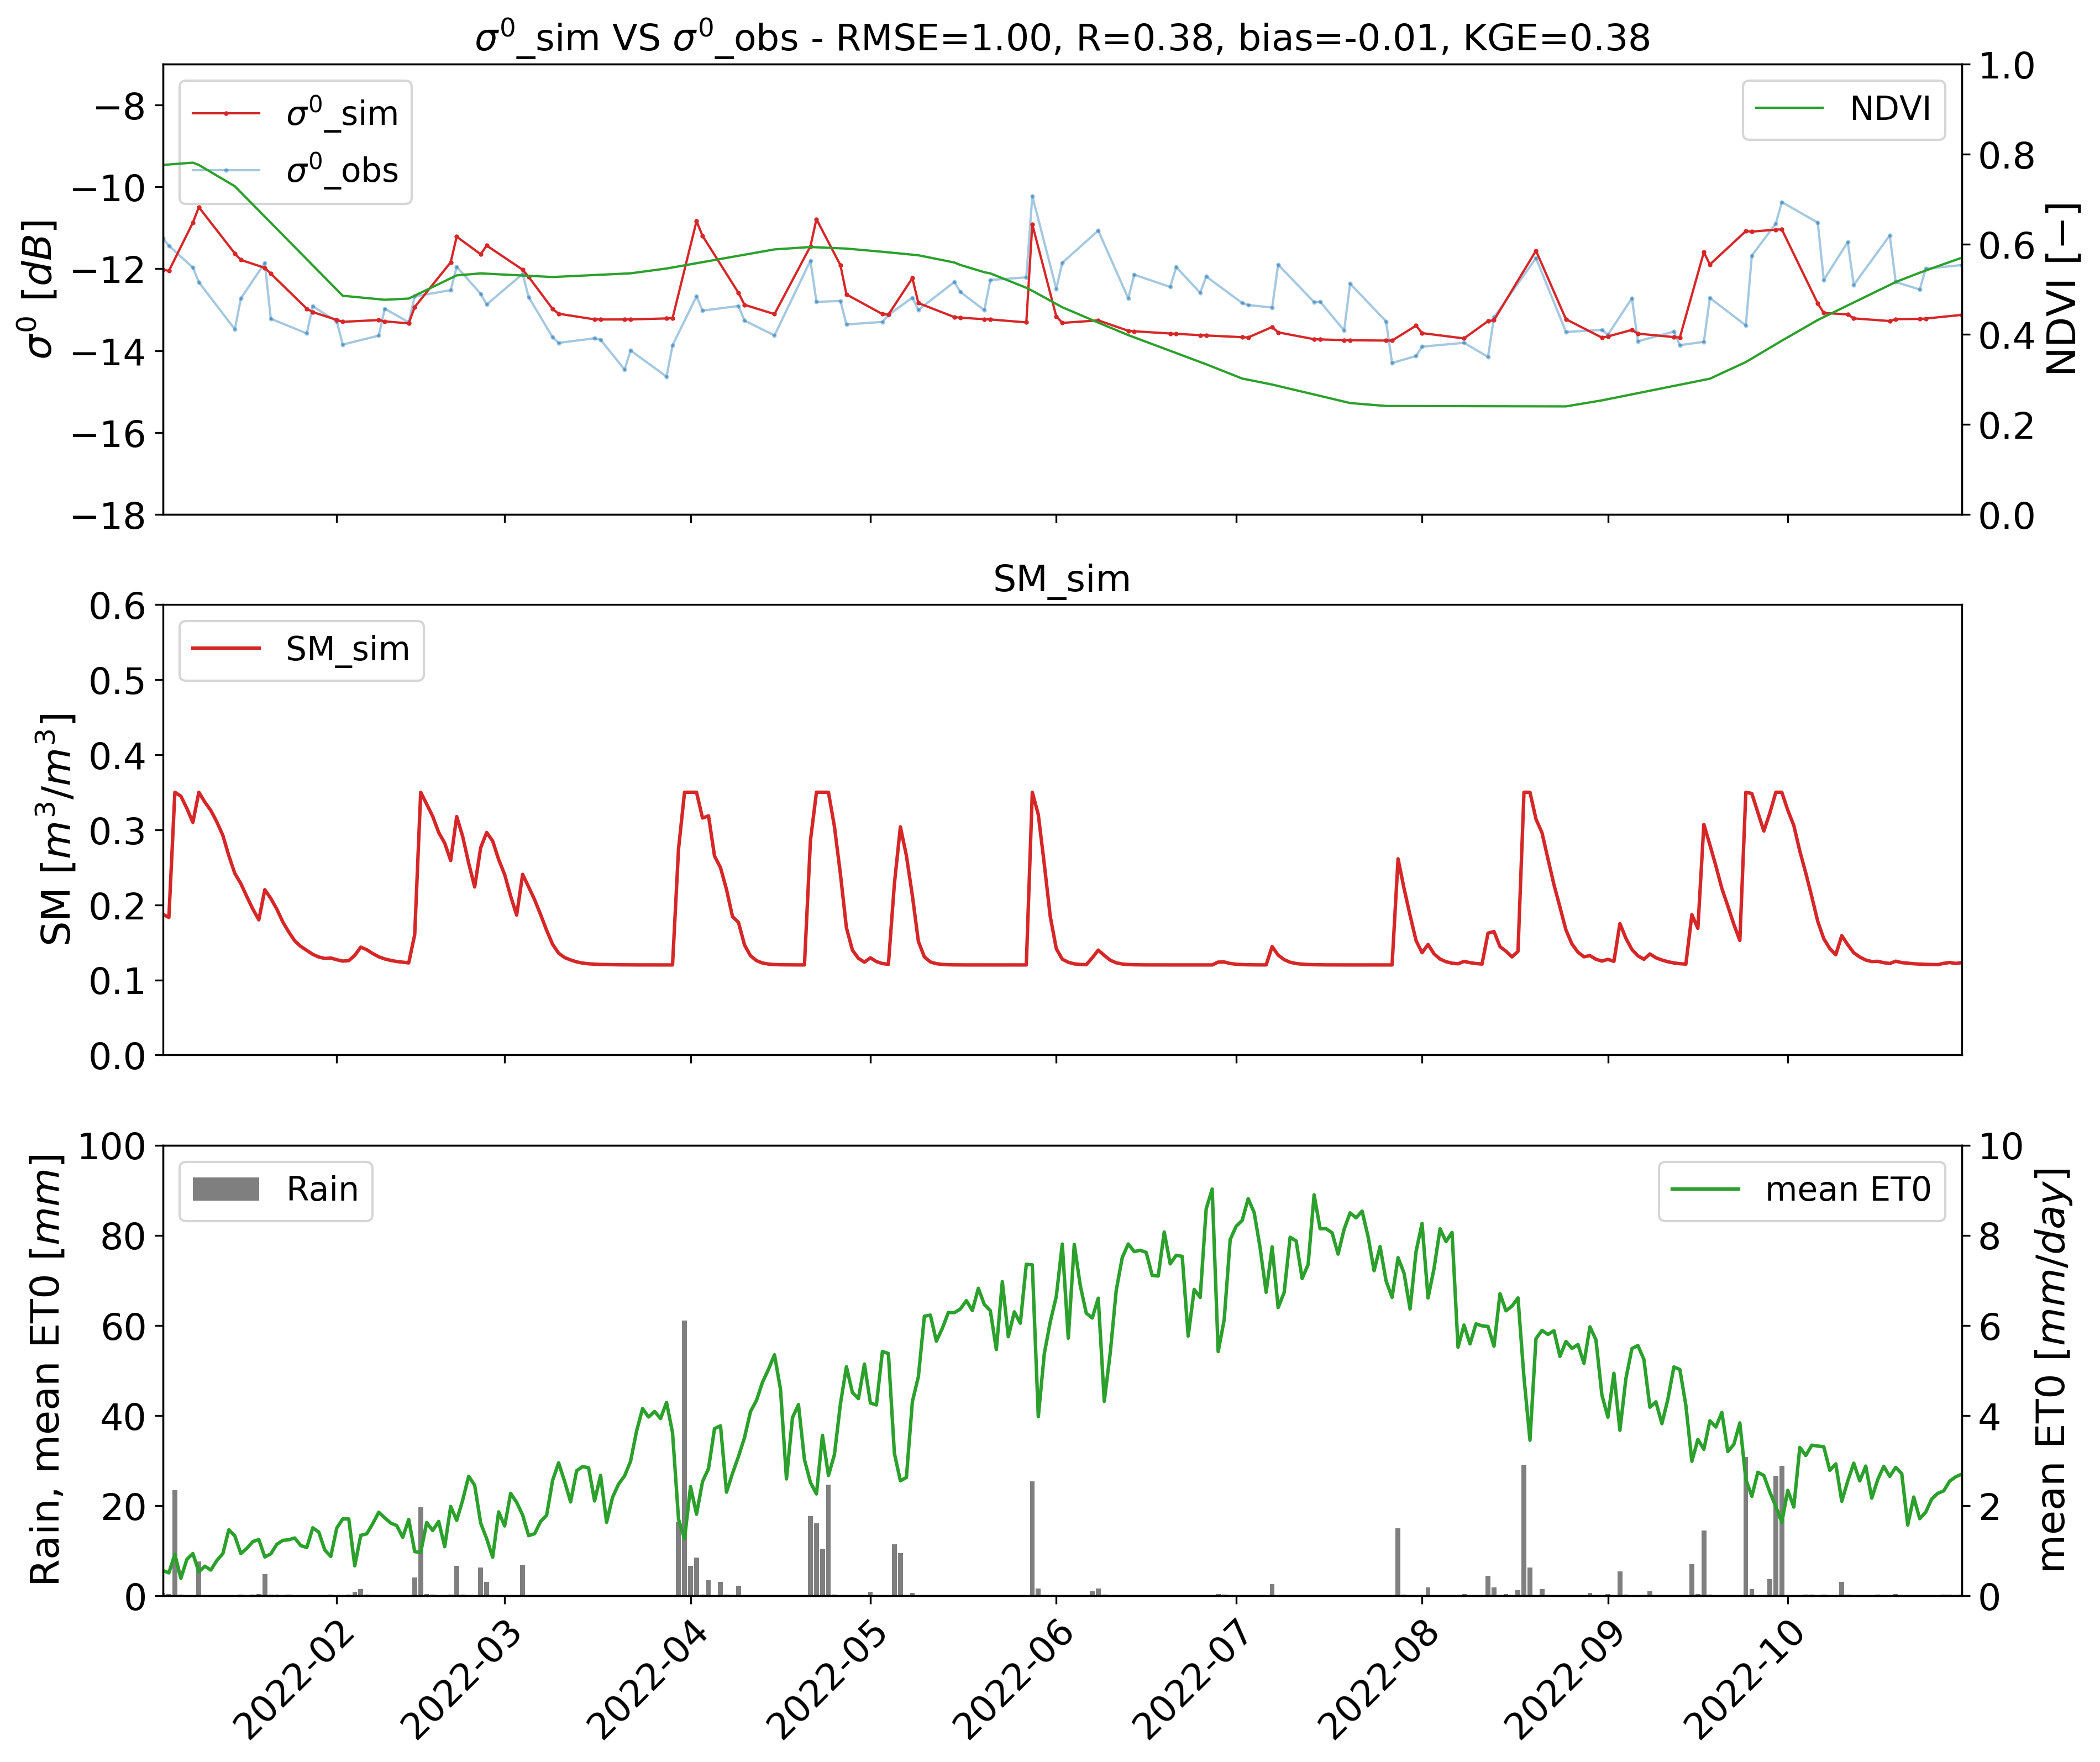

In [158]:
#####################################################################
# Triple plot
#####################################################################
opt_show=True    
from scipy.signal import savgol_filter
        
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(14, 12), sharex=True,dpi=300,)


filename = f'_triple'+PAR_str_add
from scipy.signal import savgol_filter

plot_triple(fig, ax,
            times1=t_sat, data1=[s0, sigma0], data1_label=r'$\sigma^0$', 
            input1=veg, input1_label='NDVI',
            times2=t, data2=[WW], data2_label=r'SM',
            input2=[], input2_label='',
            times3=t, data3=
            [P, EPOT],
            data3_label=['Rain', 'mean ET0'],
            user_input=[''],
           )

for axi in ax:
    axi.set_xlim(xmin=t_sat[0], xmax=t_sat[-1])
    axi.tick_params(axis='both', labelsize=16)
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    plt.savefig(root+timestr+filename+'.svg')

if opt_show: plt.show()
plt.close()

In [159]:
min(WW)

0.12000000248354453

## Scatterplot